In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [137]:
import torch
torch.cuda.set_device(0)
import os
from pathlib import Path
import json
from fastai import *
from fastai.dataset import *
from fastai.conv_learner import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patheffects

## Load Data

In [127]:
data_dir = Path('/mnt/data/extracts/pascal')
JPEGS = data_dir/'VOCdevkit/VOC2007/JPEGImages/'

In [4]:
train = json.load(open(data_dir/'pascal_train2007.json'))
val = json.load(open(data_dir/'pascal_val2007.json'))
test = json.load(open(data_dir/'pascal_test2007.json'))

### Create File Lookups

In [5]:
all_images = train['images'] + val['images'] + test['images']
fnid = {x['file_name']: x['id'] for x in all_images}

### Create DataFrames

In [6]:
def create_df(d):
    anno = d['annotations']
    fnid = [{'file_name': x['file_name'], 'image_id': x['id']} for x in d['images']]
    cats = [{'category_id': x['id'], 'category_name': x['name']} for x in d['categories']]
    anno_df = pd.DataFrame.from_dict(anno)
    fname_df = pd.DataFrame.from_dict(fnid)
    cat_df = pd.DataFrame(cats)
    df = pd.merge(anno_df, cat_df, how='inner', on='category_id')
    df = pd.merge(df, fname_df, how='inner', on='image_id')
    return df

def get_largest(df):
    return df.sort_values('area', ascending=False).groupby(['image_id']).first().reset_index()

In [8]:
train_df = create_df(train)
val_df = create_df(val)
test_df = create_df(test)
comb_df = pd.concat([train_df, val_df], axis=0)

In [32]:
trn_lrg_df = get_largest(train_df)
val_lrg_df = get_largest(val_df)
comb_lrg_df = get_largest(comb_df)

### Setup Plotting functions

In [155]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_anno(ax, x, y, anno):
    text = ax.text(x, y, anno, fontsize=14, color='white', weight='bold', 
                   verticalalignment='top')
    draw_outline(text, 1)
    
def draw_rect(ax, bbox):
    x = bbox[0]
    y = bbox[1]
    h = bbox[2]
    w = bbox[3]
    ax.add_patch(patches.Rectangle((x, y), h, w, fill=False, edgecolor='white', lw=2))
    
def show_img(img, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    return fig, ax
    
def plot_idx(image_id, figsize=(16, 8)):
    rel = comb_lrg_df.loc[comb_lrg_df.image_id == image_id].iloc[0]
    fname = rel.file_name
    cat = rel.category_name
    bbox = rel.bbox
    f_path = JPEGS/fname
    img = open_image(f_path)
    fix, ax = show_img(img)
    draw_rect(ax, bbox)
    draw_anno(ax, bbox[0], bbox[1], cat)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

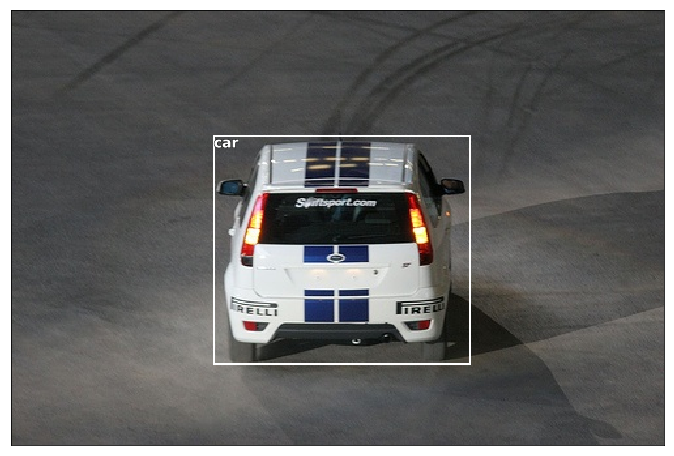

In [156]:
plot_idx(12)

## Setup Convolutional Model

In [164]:
f_model = resnet34
TMP = data_dir/'tmp'
TMP.mkdir(exist_ok=True)
CSV = Path(TMP/'train.csv')
MODEL = Path('/mnt/models/pascal')
pd.DataFrame({'fn': train_df.file_name, 'cat': train_df.category_id},
             columns=['fn', 'cat']).to_csv(CSV, index=False)
sz = 224

In [171]:
tfms = tfms_from_model(f_model, sz=sz)
md = ImageClassifierData.from_csv(MODEL, JPEGS, CSV, skip_header=True, tfms=tfms)

In [172]:
learn = ConvLearner.pretrained(f_model, md)

In [173]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 92/99 [00:37<00:02,  2.48it/s, loss=9.83]

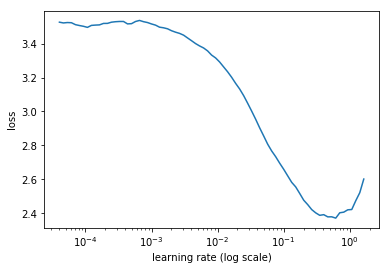

In [178]:
learn.sched.plot()
lr = 2*1e-2

In [180]:
learn.fit(lr, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 10%|█         | 10/99 [00:05<00:51,  1.72it/s, loss=3.28]


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.272311   0.844297   0.74625   



[0.8442966, 0.74625]